In [3]:
# libraries
import pandas as pd
import numpy as np
from plotnine import *

# data
file_path = "C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/machine_learning/project/ML_calibration_graph_linearity/0_data/data_ready_addfeatures_231122.csv"
df_calibrations = pd.read_csv(file_path)

In [4]:
print(df_calibrations.columns.tolist())

['lab', 'compound', 'sample_type', 'RT', 'sample', 'peak_area', 'note', 'c_real_M', 'rf', 'rf_error', 'slope', 'intercept', 'residuals', 'abs_residuals', 'peak_area_norm1', 'c_real_M_norm1', 'rf_norm1', 'rf_error_norm1', 'residuals_norm1', 'abs_residuals_norm1', 'peak_area_norm2', 'c_real_M_norm2', 'rf_norm2', 'rf_error_norm2', 'residuals_norm2', 'abs_residuals_norm2']


In [5]:
df_calibrations.head()

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M,rf,rf_error,...,rf_norm1,rf_error_norm1,residuals_norm1,abs_residuals_norm1,peak_area_norm2,c_real_M_norm2,rf_norm2,rf_error_norm2,residuals_norm2,abs_residuals_norm2
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06,4.569604e+13,5.291853e+12,...,0.701721,0.374456,0.813764,0.304243,1.000000,1.000000,0.228448,0.284072,0.94932,0.290641
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06,3.994483e+13,1.104306e+13,...,0.613404,0.781418,-2.674721,1.000000,0.357888,0.410896,0.000000,0.749835,0.00000,1.000000
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06,4.920374e+13,1.784153e+12,...,0.755586,0.126248,1.000000,0.373871,0.227299,0.211853,0.367780,0.000000,1.00000,0.361630
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07,4.891860e+13,2.069294e+12,...,0.751207,0.146425,0.481422,0.179990,0.129248,0.121641,0.356453,0.023092,0.85888,0.163958
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07,5.704416e+13,6.056272e+12,...,0.875986,0.428547,0.430823,0.161072,0.042528,0.034479,0.679215,0.345978,0.84511,0.144671


I will try to recalculate the rf_error, and instead of using the mean(rf) I will take the difference between the single-point rf and the slope-rf. I will use both the "dummy" slope (fitted to all points for each lab/compound), and a "smarter" slope (i.e., only fitted to the points labeled as linear).

In [7]:
from sklearn.linear_model import LinearRegression

# Empty lists to store recalculated rf_error values
rf_error_smart_norm1 = []
rf_error_smart_norm2 = []
rf_error_dummy_norm1 = []
rf_error_dummy_norm2 = []

# Iterate over each lab and compound combination
for lab in df_calibrations['lab'].unique():
    for compound in df_calibrations['compound'].unique():
        subset = df_calibrations[(df_calibrations['lab'] == lab) & (df_calibrations['compound'] == compound)]

        # Linear regression on points labeled as linear (smart_lr)
        linear_points = subset[subset['note'] == 'linear']
        if not linear_points.empty:
            model = LinearRegression()
            model.fit(linear_points[['c_real_M']], linear_points['peak_area'])
            lin_slope = model.coef_[0]
        else:
            lin_slope = 0  # Handle cases with no linear points

        # Calculate new rf_error_smart 
        subset['rf_error_smart'] = np.abs(subset['rf'] - lin_slope)
        max_rf_error_smart = subset['rf_error_smart'].max()
        min_rf_error_smart = subset['rf_error_smart'].min()

        # Normalize rf_error_smart with norm1 approach
        subset['rf_error_smart_max_norm'] = subset['rf_error_smart'] / max_rf_error_smart if max_rf_error_smart != 0 else 0

        # And with norm2 approach
        subset['rf_error_smart_min_max_norm'] = ((subset['rf_error_smart'] - min_rf_error_smart) / (max_rf_error_smart - min_rf_error_smart)
                                           if max_rf_error_smart != min_rf_error_smart else 0)

        rf_error_smart_norm1.extend(subset['rf_error_smart_max_norm'].tolist())
        rf_error_smart_norm2.extend(subset['rf_error_smart_min_max_norm'].tolist())

        # Linear regression on all point (dummy_lr)
        if not subset.empty:
            model = LinearRegression()
            model.fit(subset[['c_real_M']], subset['peak_area'])
            dummy_slope = model.coef_[0]
        else:
            dummy_slope = 0  # Handle cases with no points

        # Calculate new rf_error_dummy 
        subset['rf_error_dummy'] = np.abs(subset['rf'] - dummy_slope)
        max_rf_error_dummy = subset['rf_error_dummy'].max()
        min_rf_error_dummy = subset['rf_error_dummy'].min()

        # Normalize rf_error_dummy with norm1 approach
        subset['rf_error_dummy_max_norm'] = subset['rf_error_dummy'] / max_rf_error_dummy if max_rf_error_smart != 0 else 0

        # And with norm2 approach
        subset['rf_error_dummy_min_max_norm'] = ((subset['rf_error_dummy'] - min_rf_error_dummy) / (max_rf_error_dummy - min_rf_error_dummy)
                                           if max_rf_error_dummy != min_rf_error_dummy else 0)

        rf_error_dummy_norm1.extend(subset['rf_error_dummy_max_norm'].tolist())
        rf_error_dummy_norm2.extend(subset['rf_error_dummy_min_max_norm'].tolist())

# Add the new normalized rf_error values to the original DataFrame
df_calibrations['rf_error_smart_norm1'] = rf_error_smart_norm1
df_calibrations['rf_error_smart_norm2'] = rf_error_smart_norm2
df_calibrations['rf_error_dummy_norm1'] = rf_error_dummy_norm1
df_calibrations['rf_error_dummy_norm2'] = rf_error_dummy_norm2

C:\Users\loma5202\AppData\Local\Temp\ipykernel_22752\2385757823.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\loma5202\AppData\Local\Temp\ipykernel_22752\2385757823.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\loma5202\AppData\Local\Temp\ipykernel_22752\2385757823.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [9]:
df_calibrations.head()

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M,rf,rf_error,...,peak_area_norm2,c_real_M_norm2,rf_norm2,rf_error_norm2,residuals_norm2,abs_residuals_norm2,rf_error_smart_norm1,rf_error_smart_norm2,rf_error_dummy_norm1,rf_error_dummy_norm2
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06,4.569604e+13,5.291853e+12,...,1.000000,1.000000,0.228448,0.284072,0.94932,0.290641,0.648026,0.630869,0.037912,0.000000
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06,3.994483e+13,1.104306e+13,...,0.357888,0.410896,0.000000,0.749835,0.00000,1.000000,1.000000,1.000000,0.246951,0.217277
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06,4.920374e+13,1.784153e+12,...,0.227299,0.211853,0.367780,0.000000,1.00000,0.361630,0.433355,0.405734,0.211652,0.180586
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07,4.891860e+13,2.069294e+12,...,0.129248,0.121641,0.356453,0.023092,0.85888,0.163958,0.450806,0.424035,0.197529,0.165907
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07,5.704416e+13,6.056272e+12,...,0.042528,0.034479,0.679215,0.345978,0.84511,0.144671,0.046479,0.000000,0.599996,0.584234


In [19]:
df_calibrations.to_csv("C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/machine_learning/project/data_rf_errors_231124.csv", index = False)

Visualisation of the errors with different methods for calculating and normalising

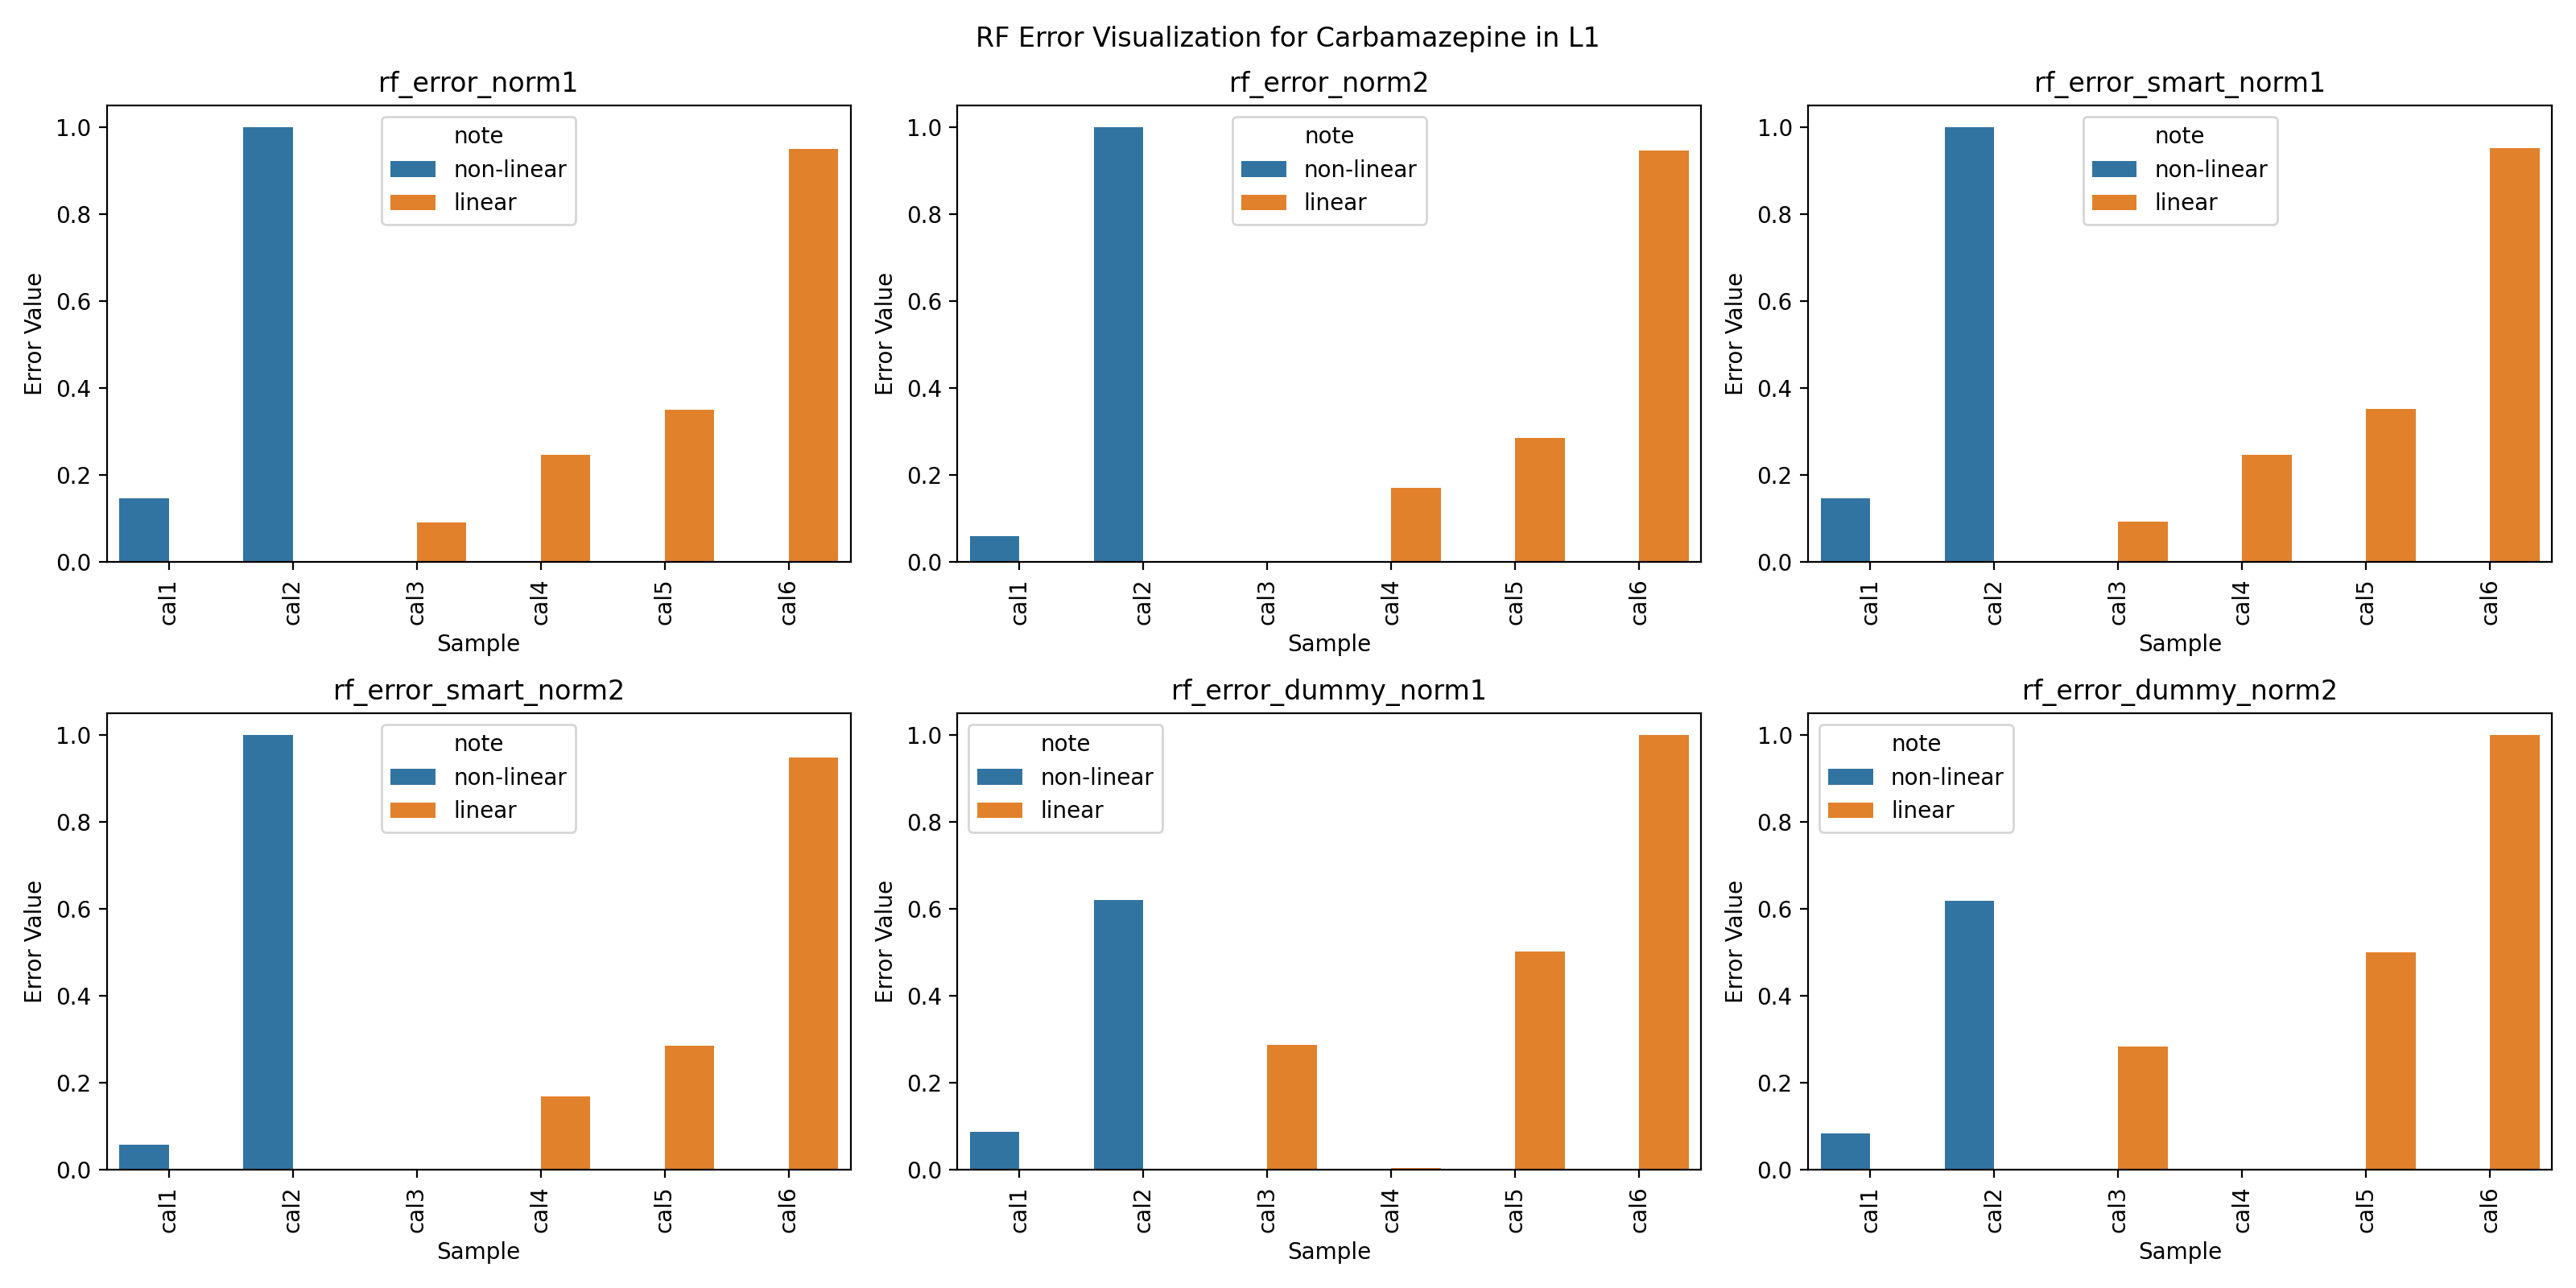

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

## Graph 1 - Carbamazepine for L1
# Select a specific compound and lab
selected_compound = 'Carbamazepine'  # Replace with actual compound name
selected_lab = 'L1'  # Replace with actual lab name
subset = df_calibrations[(df_calibrations['compound'] == selected_compound) &
                       (df_calibrations['lab'] == selected_lab)]

# List of error methods for iteration
error_methods = ['rf_error_norm1', 'rf_error_norm2', 
                 'rf_error_smart_norm1', 'rf_error_smart_norm2',
                 'rf_error_dummy_norm1', 'rf_error_dummy_norm2']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

# Iterate over the error methods and create a subplot for each
for i, method in enumerate(error_methods):
    ax = axes[i // 3, i % 3]  # Determine the position of the subplot
    sns.barplot(data=subset, x='sample', y=method, hue='note', ax=ax)
    ax.set_title(method)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error Value')
    ax.tick_params(axis='x', rotation=90)

fig.suptitle(f'RF Error Visualization for {selected_compound} in {selected_lab}')
plt.tight_layout()
plt.show()


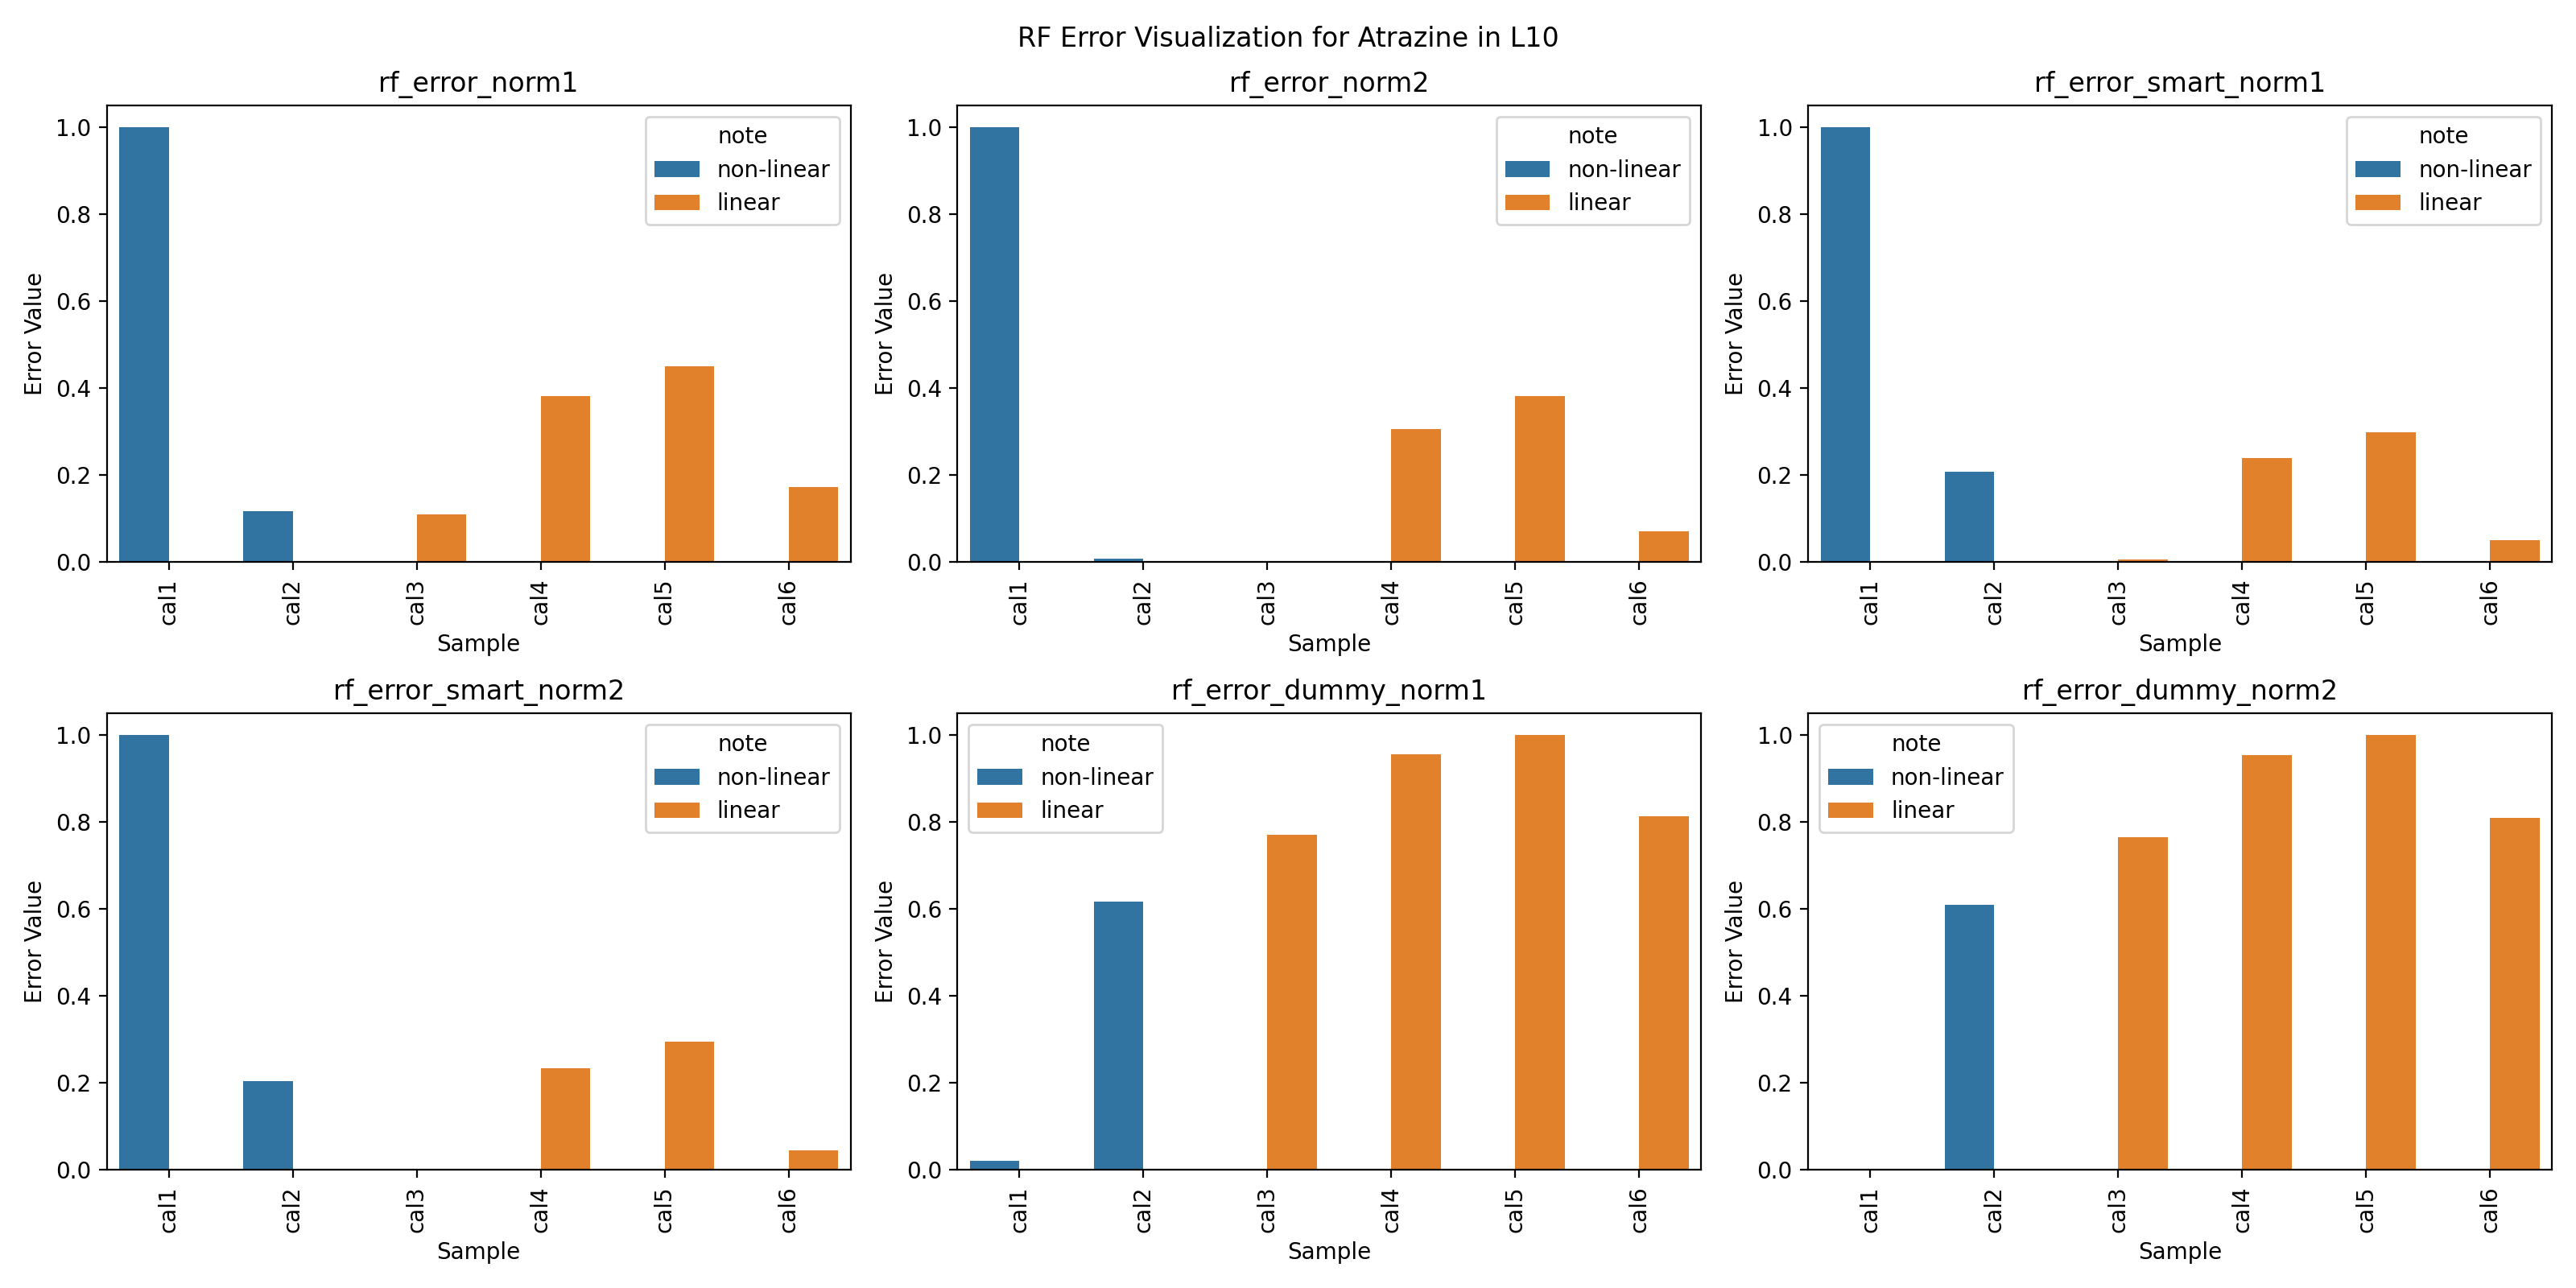

In [34]:
## Graph 2 - Atrazine for L10
selected_compound = 'Atrazine'  # Replace with actual compound name
selected_lab = 'L10'  # Replace with actual lab name
subset = df_calibrations[(df_calibrations['compound'] == selected_compound) &
                       (df_calibrations['lab'] == selected_lab)]

# List of error methods for iteration
error_methods = ['rf_error_norm1', 'rf_error_norm2', 
                 'rf_error_smart_norm1', 'rf_error_smart_norm2',
                 'rf_error_dummy_norm1', 'rf_error_dummy_norm2']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

# Iterate over the error methods and create a subplot for each
for i, method in enumerate(error_methods):
    ax = axes[i // 3, i % 3]  # Determine the position of the subplot
    sns.barplot(data=subset, x='sample', y=method, hue='note', ax=ax)
    ax.set_title(method)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error Value')
    ax.tick_params(axis='x', rotation=90)

fig.suptitle(f'RF Error Visualization for {selected_compound} in {selected_lab}')
plt.tight_layout()
plt.show()

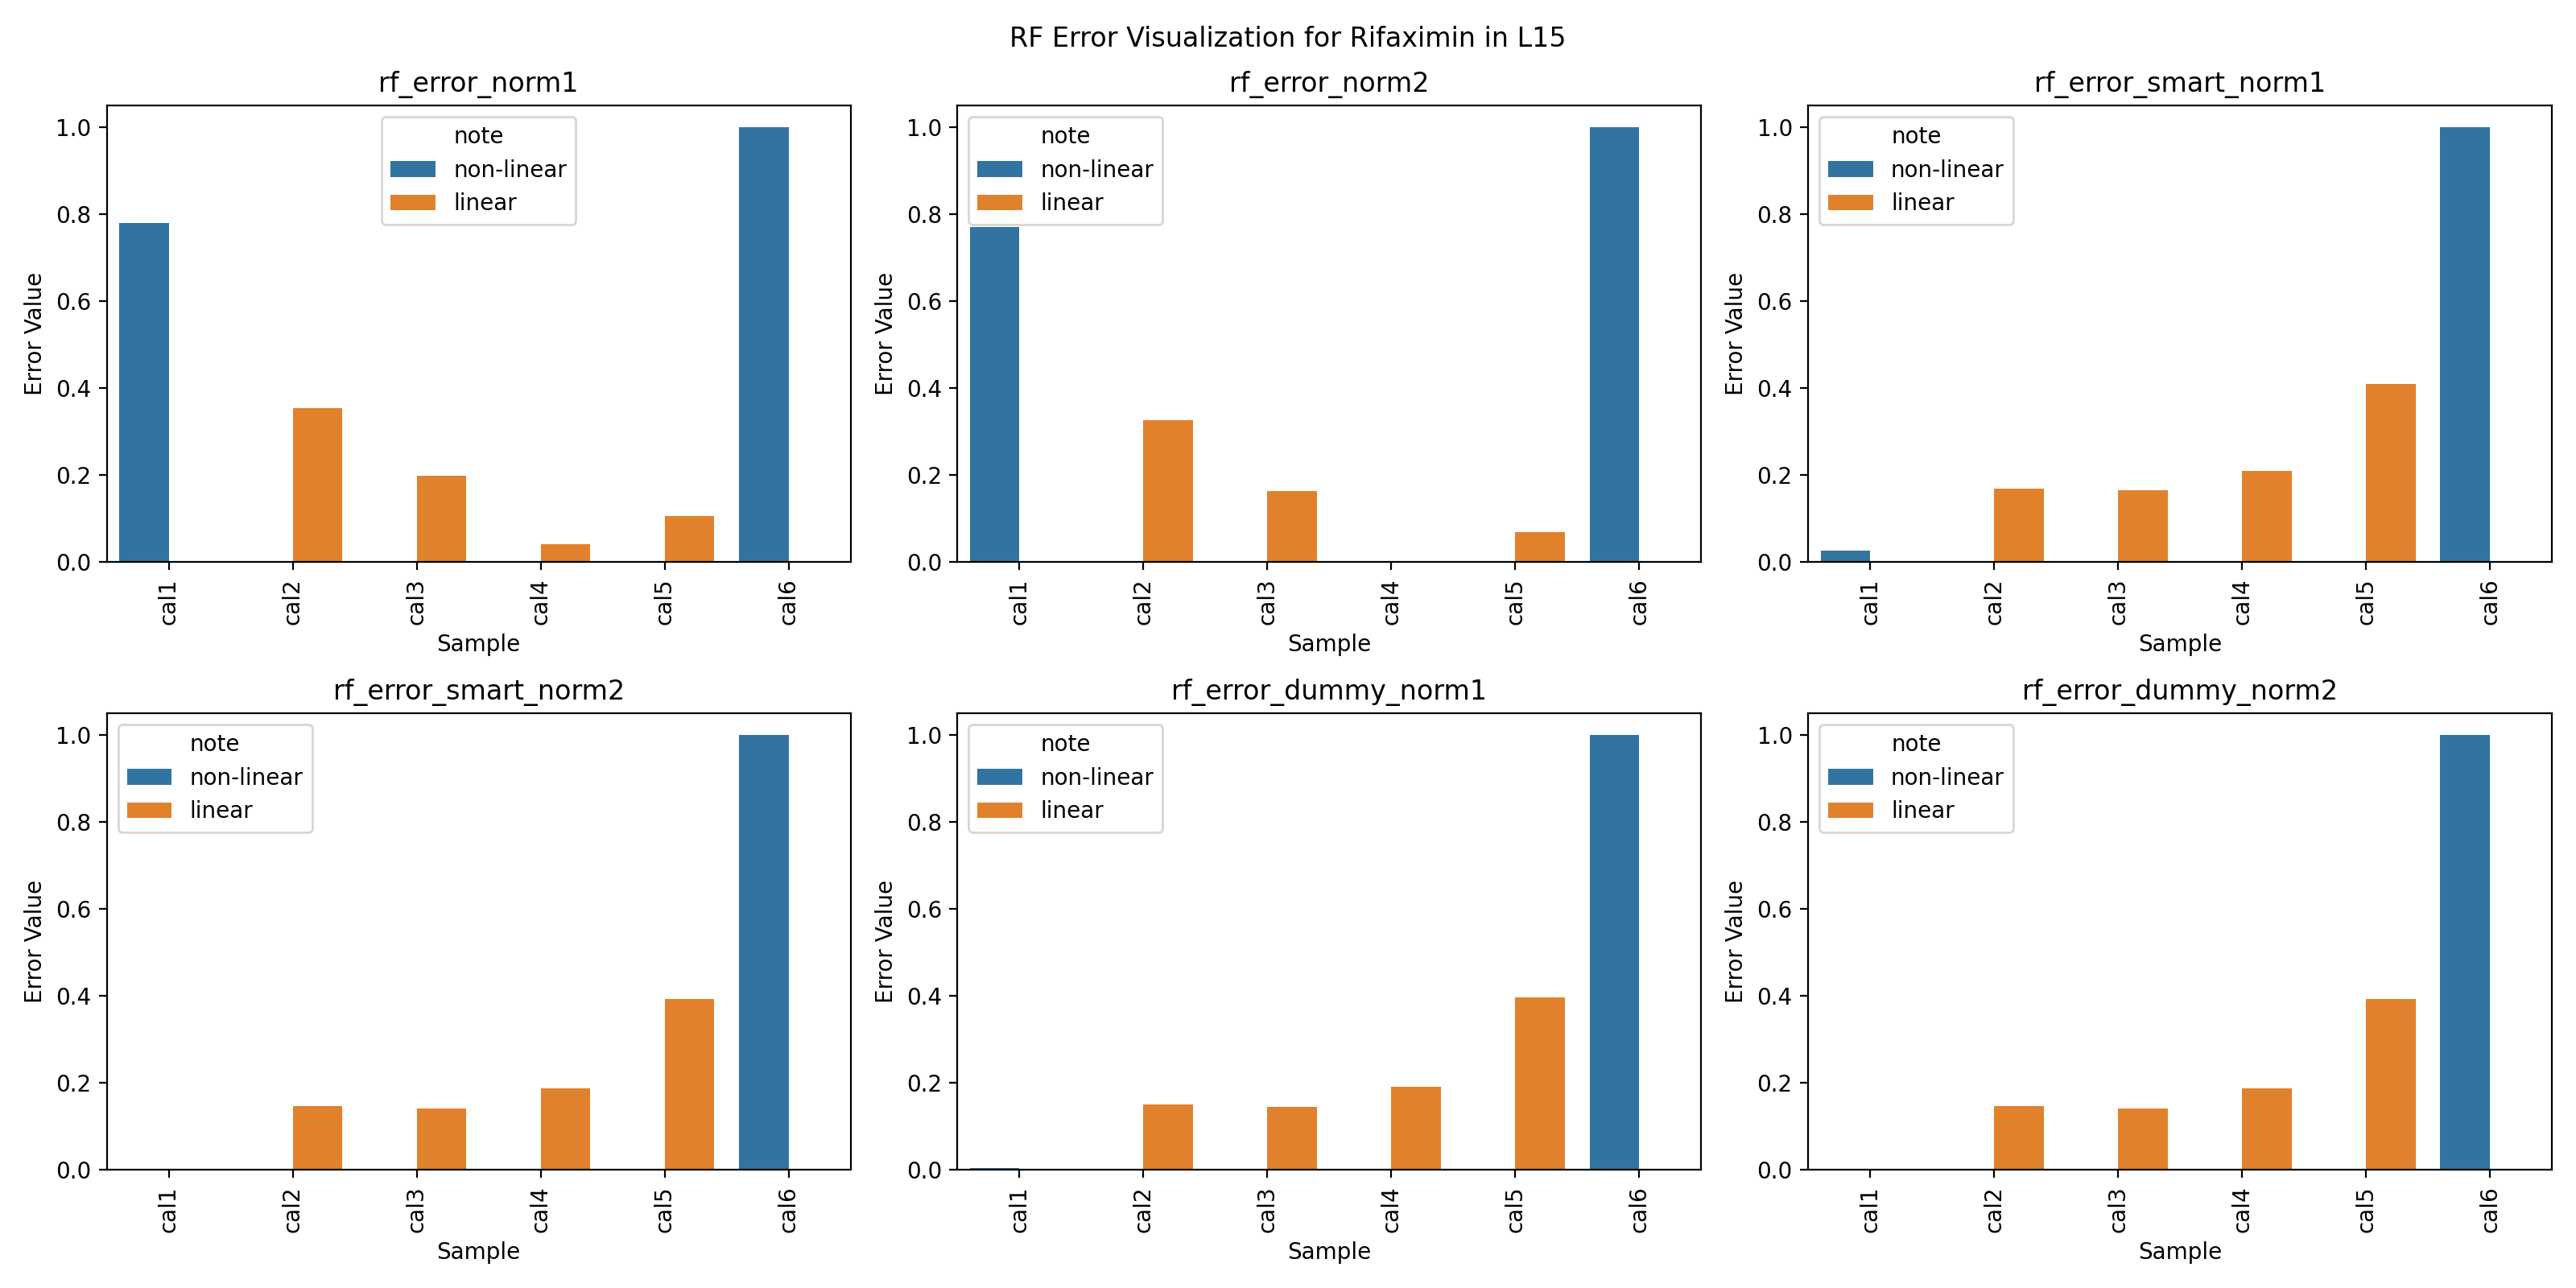

In [32]:
## Graph 3 - Rifaximin for L15
selected_compound = 'Rifaximin'  # Replace with actual compound name
selected_lab = 'L15'  # Replace with actual lab name
subset = df_calibrations[(df_calibrations['compound'] == selected_compound) &
                       (df_calibrations['lab'] == selected_lab)]

# List of error methods for iteration
error_methods = ['rf_error_norm1', 'rf_error_norm2', 
                 'rf_error_smart_norm1', 'rf_error_smart_norm2',
                 'rf_error_dummy_norm1', 'rf_error_dummy_norm2']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

# Iterate over the error methods and create a subplot for each
for i, method in enumerate(error_methods):
    ax = axes[i // 3, i % 3]  # Determine the position of the subplot
    sns.barplot(data=subset, x='sample', y=method, hue='note', ax=ax)
    ax.set_title(method)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error Value')
    ax.tick_params(axis='x', rotation=90)

fig.suptitle(f'RF Error Visualization for {selected_compound} in {selected_lab}')
plt.tight_layout()
plt.show()

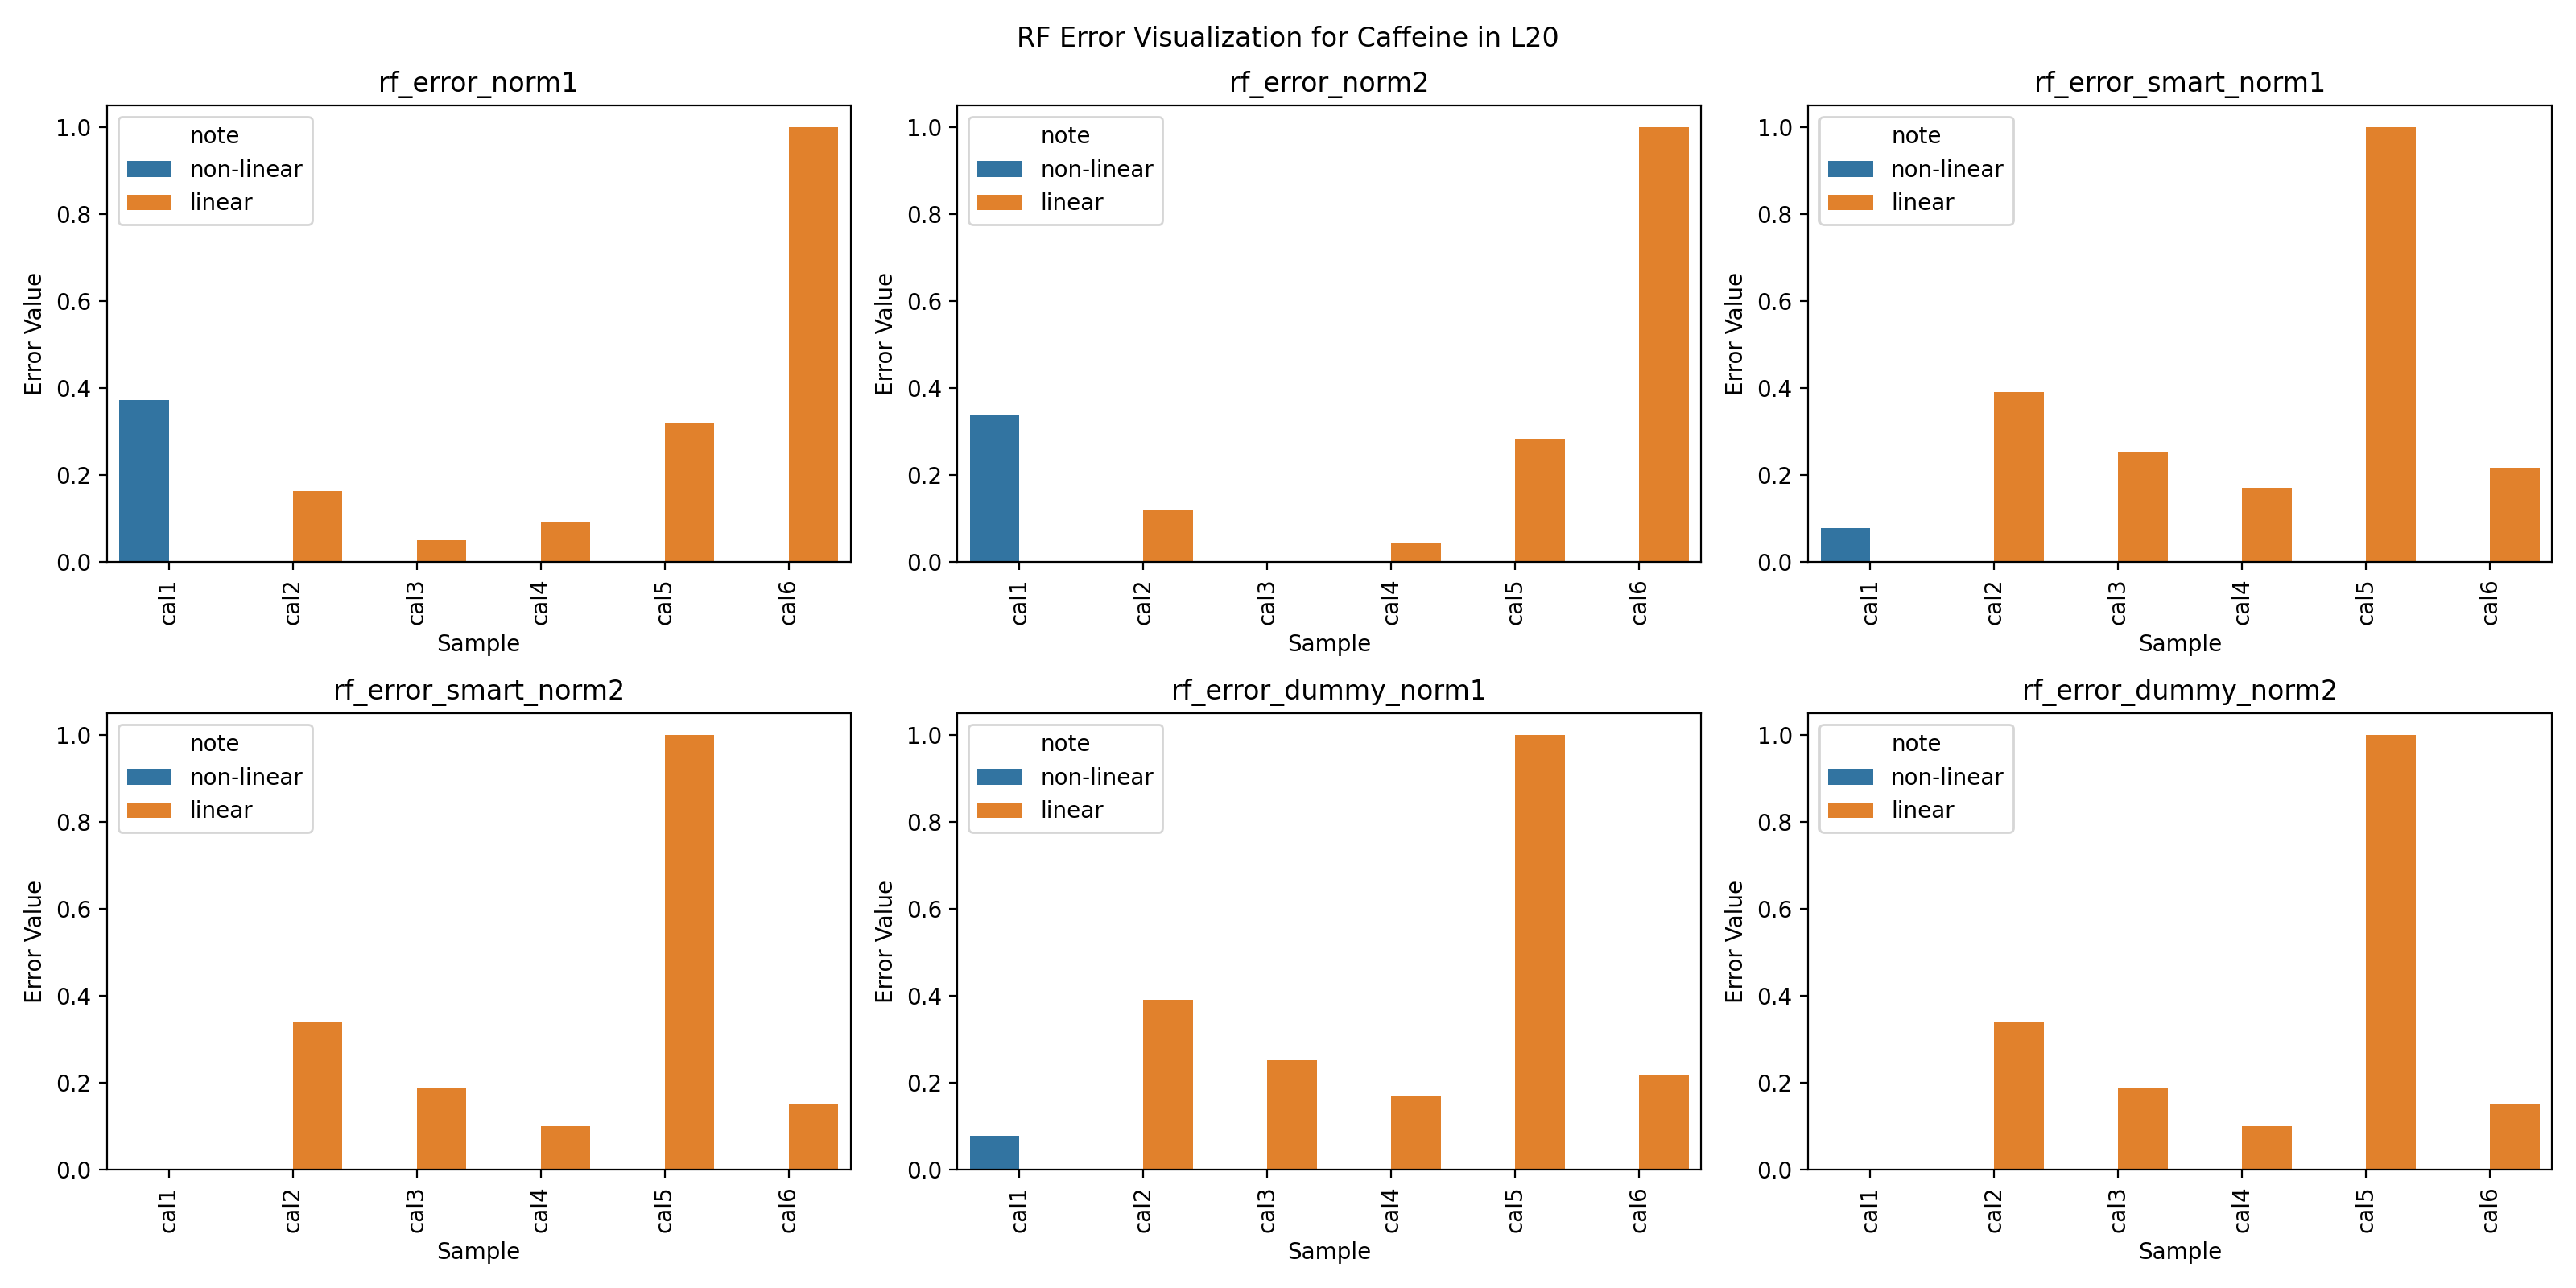

In [33]:
## Graph 4 - Caffeine for L20
selected_compound = 'Caffeine'  # Replace with actual compound name
selected_lab = 'L20'  # Replace with actual lab name
subset = df_calibrations[(df_calibrations['compound'] == selected_compound) &
                       (df_calibrations['lab'] == selected_lab)]

# List of error methods for iteration
error_methods = ['rf_error_norm1', 'rf_error_norm2', 
                 'rf_error_smart_norm1', 'rf_error_smart_norm2',
                 'rf_error_dummy_norm1', 'rf_error_dummy_norm2']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

# Iterate over the error methods and create a subplot for each
for i, method in enumerate(error_methods):
    ax = axes[i // 3, i % 3]  # Determine the position of the subplot
    sns.barplot(data=subset, x='sample', y=method, hue='note', ax=ax)
    ax.set_title(method)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error Value')
    ax.tick_params(axis='x', rotation=90)

fig.suptitle(f'RF Error Visualization for {selected_compound} in {selected_lab}')
plt.tight_layout()
plt.show()